<a href="https://colab.research.google.com/github/vikash18o19/Soil-GAN/blob/main/Copy_of_400_epochs_no_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function

from PIL import Image
from IPython.display import HTML

import os
import torch
import random
import argparse
import torch.utils.data
import torch.nn.parallel

import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torchvision.datasets as dset
import torch.backends.cudnn as cudnn
import matplotlib.animation as animation
import torchvision.transforms as transforms

manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  1506


In [ ]:
dir_soil = "/content/drive/MyDrive/dataset_soil/Soil_images/"

# Number of workers for pytorch dataloader
num_workers = 2

image_dim = 64
color_dim = 3

latent_dim = 128

generator_feature_dim = 64
discriminator_feature_dim = 64

num_epochs = 400

lr = 0.0002
beta1 = 0.5

# Number of GPUs available
num_gpus = 1

batch_size = 64

In [ ]:
files_soil = os.listdir(dir_soil +'/Soil_images')

num_soil = len(files_soil)

print(num_soil)

image = Image.open("/content/drive/MyDrive/dataset_soil/Soil_images/Soil_images/1.jpeg")

width, height = image.size

print(f"Image dimension: {width} x {height}")

903
Image dimension: 259 x 194


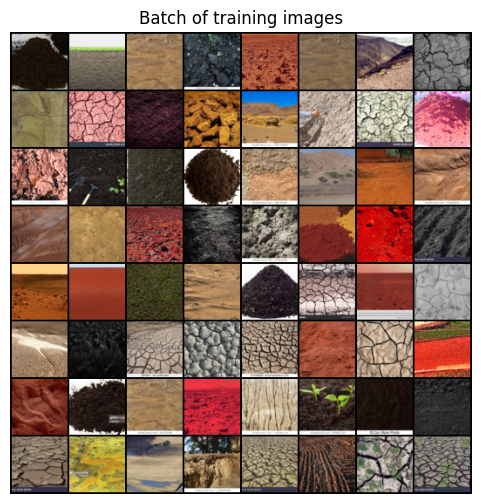

In [ ]:
# Create the dataset
dataset = dset.ImageFolder(root=dir_soil,
                           transform=transforms.Compose([
                               transforms.Resize(image_dim),
                               transforms.CenterCrop(image_dim),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# Define the data augmentation transforms
transform = transforms.Compose([
    transforms.Resize(image_dim),
    transforms.CenterCrop(image_dim),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # transforms.RandomRotation(degrees=10),
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=None, interpolation=transforms.InterpolationMode.BILINEAR, fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Create the augmented dataset
augmented_dataset = dset.ImageFolder(root=dir_soil, transform=transform)

# Combine the original and augmented datasets
combined_dataset = torch.utils.data.ConcatDataset([dataset, augmented_dataset])

# Create the dataloader for the combined dataset
dataloader = torch.utils.data.DataLoader(combined_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and num_gpus > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(6, 6))
plt.axis("off")
plt.title("Batch of training images")
plt.imshow(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu().numpy().transpose(1,2,0))

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        

In [ ]:
class Generator(nn.Module):
    def __init__(self, num_gpus):
        super(Generator, self).__init__()
        self.num_gpus = num_gpus
        self.main = nn.Sequential(
            
            nn.ConvTranspose2d(latent_dim, generator_feature_dim * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(generator_feature_dim * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(generator_feature_dim * 8, generator_feature_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(generator_feature_dim * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(generator_feature_dim * 4, generator_feature_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(generator_feature_dim * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(generator_feature_dim * 2, generator_feature_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(generator_feature_dim),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(generator_feature_dim, color_dim, 4, 2, 1, bias=False),
            nn.Tanh()
            
        )

    def forward(self, input):
        return self.main(input)



In [ ]:
# Create the generator
model_generator = Generator(num_gpus).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (num_gpus > 1):
    model_generator = nn.DataParallel(model_generator, list(range(num_gpus)))

# Apply the weights_init function to randomly initialize all weights
model_generator.apply(weights_init)

# Print the model
print(model_generator)



Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


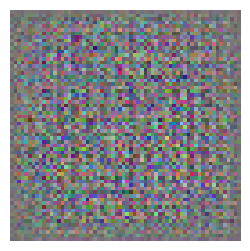

In [ ]:
random_latent_vector = torch.randn(1, latent_dim, 1, 1, device=device)

generated_image = model_generator(random_latent_vector)

plt.figure(figsize=(3, 3))
plt.imshow(vutils.make_grid(generated_image, normalize=True).cpu().numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()



In [ ]:
class Discriminator(nn.Module):
    def __init__(self, num_gpus):
        super(Discriminator, self).__init__()
        self.num_gpus = num_gpus
        self.main = nn.Sequential(
            
            nn.Conv2d(color_dim, discriminator_feature_dim, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(discriminator_feature_dim, discriminator_feature_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(discriminator_feature_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(discriminator_feature_dim * 2, discriminator_feature_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(discriminator_feature_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(discriminator_feature_dim * 4, discriminator_feature_dim * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(discriminator_feature_dim * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(discriminator_feature_dim * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            
        )

    def forward(self, input):
        return self.main(input)




In [ ]:
# Create the Discriminator
model_discriminator = Discriminator(num_gpus).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (num_gpus > 1):
    model_discriminator = nn.DataParallel(model_discriminator, list(range(num_gpus)))

# Apply the weights_init function to randomly initialize all weights
model_discriminator.apply(weights_init)

# Print the model
print(model_discriminator)



Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Fixed noise for displaying example outputs
fixed_noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(model_discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(model_generator.parameters(), lr=lr, betas=(beta1, 0.999))



In [ ]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        # Training discriminator
        
        ## Train with all-real batch
        model_discriminator.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch
        output_real = model_discriminator(real_cpu).view(-1)
        # Calculate loss on all-real batch
        loss_real = criterion(output_real, label)
        # Calculate gradients in backward pass
        loss_real.backward()
        
        D_x = output_real.mean().item()

        ## Train with all-fake batch
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        # Generate fake image batch
        fake = model_generator(noise)
        label.fill_(fake_label)
        # Classify all fake batch
        output_fake = model_discriminator(fake.detach()).view(-1)
        # Calculate loss on the all-fake batch
        loss_fake = criterion(output_fake, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        loss_fake.backward()
        
        D_G_z1 = output_fake.mean().item()
        
        loss_discriminator = loss_real + loss_fake
        
        # Update discriminator
        optimizerD.step()
        
        # Training generator
        
        model_generator.zero_grad()
        label.fill_(real_label)
        # perform another forward pass of all-fake batch
        output_generator = model_discriminator(fake).view(-1)
        # Calculate loss based on this output
        loss_generator = criterion(output_generator, label)
        # Calculate gradients
        loss_generator.backward()
        
        D_G_z2 = output_generator.mean().item()
        
        # Update generator
        optimizerG.step()

        # Output training stats
        if epoch % 50 == 0 and i == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     loss_discriminator.item(), loss_generator.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(loss_generator.item())
        D_losses.append(loss_discriminator.item())

        # Check how the generator is doing by saving output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = model_generator(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

for i in range(len(fixed_noise)):
    # Generate the image from the corresponding noise vector
    with torch.no_grad():
                generated_image = model_generator(fixed_noise[i].unsqueeze(0)).detach().cpu()
    #  = generator(z[i].unsqueeze(0)).detach().cpu()
    # Construct a unique filename based on the current index
    filename = f"/content/drive/MyDrive/GAN Training/pytorch model/analysis/fake_images/image_{i+1}.png"
    # Save the image to the specified file path
    vutils.save_image(generated_image, filename, normalize=True)

Starting Training Loop...
[0/400][0/29]	Loss_D: 1.2875	Loss_G: 6.3963	D(x): 0.5925	D(G(z)): 0.4348 / 0.0023
[50/400][0/29]	Loss_D: 1.7181	Loss_G: 6.0412	D(x): 0.9656	D(G(z)): 0.7624 / 0.0039
[100/400][0/29]	Loss_D: 0.1882	Loss_G: 5.0784	D(x): 0.9858	D(G(z)): 0.1526 / 0.0095
[150/400][0/29]	Loss_D: 0.2185	Loss_G: 5.5899	D(x): 0.9926	D(G(z)): 0.1700 / 0.0100
[200/400][0/29]	Loss_D: 0.4922	Loss_G: 9.0142	D(x): 0.9972	D(G(z)): 0.3039 / 0.0007
[250/400][0/29]	Loss_D: 0.1198	Loss_G: 6.1633	D(x): 0.9859	D(G(z)): 0.0954 / 0.0038
[300/400][0/29]	Loss_D: 2.2958	Loss_G: 14.5312	D(x): 0.9995	D(G(z)): 0.6636 / 0.0000
[350/400][0/29]	Loss_D: 0.7840	Loss_G: 10.1447	D(x): 0.9999	D(G(z)): 0.3909 / 0.0003


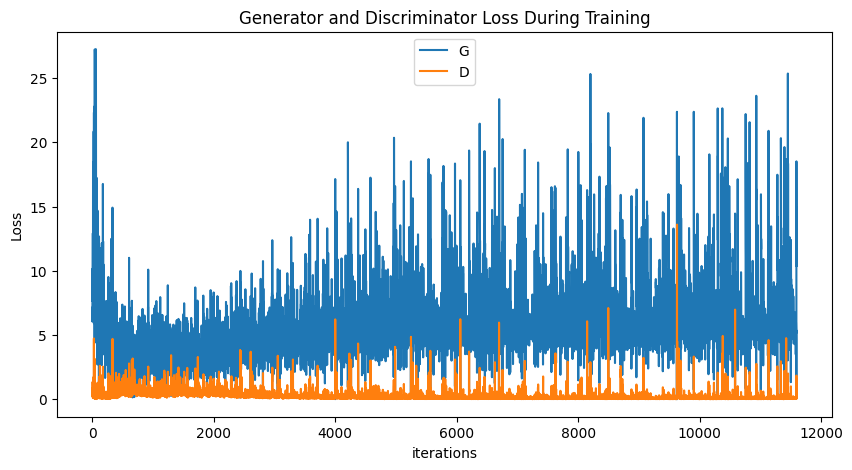

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# fig = plt.figure(figsize=(6, 6))
# plt.axis("off")
# ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
# ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# HTML(ani.to_jshtml())

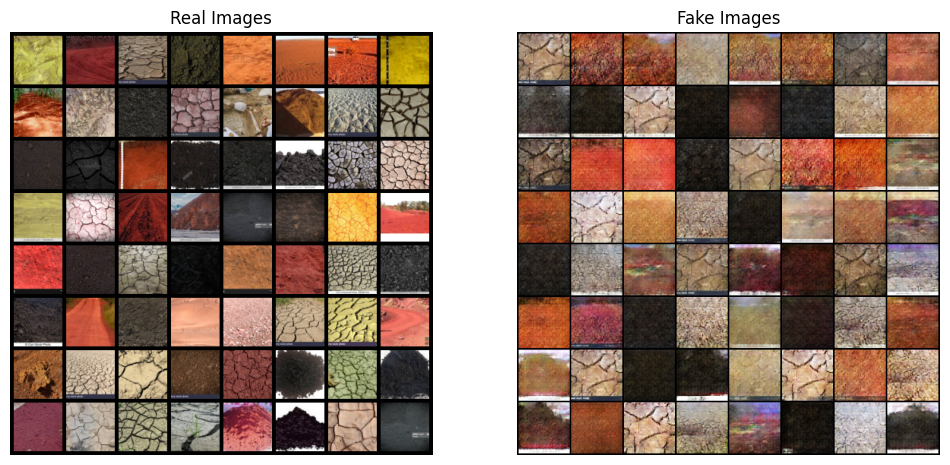

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
# torch.save(model_generator, '/content/drive/MyDrive/GAN Training/pytorch model/model_generator2.pth')

In [ ]:
# torch.save(model_generator.state_dict(), '/content/drive/MyDrive/GAN Training/pytorch model/generator_800e.pth')

In [ ]:
torch.save(model_generator.state_dict(), '/content/drive/MyDrive/GAN Training/pytorch model/generator_800_22_4_23_2nd.pth')